In [86]:
from tensorflow import keras, optimizers
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

## Data

In [50]:
X = pd.read_csv("data/train_values.csv", index_col="building_id")
Y = pd.read_csv("data/train_labels.csv", index_col="building_id") - 1

# Y = to_categorical(Y, num_classes=3)

encoded_temp = pd.get_dummies(X["count_floors_pre_eq"], prefix="count_floors").astype(int)
X_encoded = pd.get_dummies(X, dtype=int).drop(columns="count_floors_pre_eq")
for temp_col in encoded_temp.columns:
    X_encoded[temp_col] = encoded_temp[temp_col]

X0 = X_encoded.copy(deep=True)
scaler = StandardScaler()
scaled_X0 = scaler.fit_transform(X0)

pca = PCA(n_components=10)
pca_X0 = pca.fit_transform(X0)

X0_train, X0_test, Y0_train, Y0_test = train_test_split(pca_X0, Y,test_size=0.25, random_state=192)


## Neural network


In [117]:
def gen_model(layers: list=[], input_shape: tuple=()):
    model = None
    if (len(layers) != 0):
        model = keras.models.Sequential(layers)
    else:
        model = keras.models.Sequential([
            keras.layers.Input(shape=input_shape),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(3, activation="softmax")
        ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

    return model


model = gen_model(input_shape=(10,))


- early stop để quan sát giá trị loss sau mỗi epoch, nếu như 3 lần liên tiếp mà delta loss < 1e-3 thì dừng lại

In [118]:
early_stop = callbacks.EarlyStopping(monitor="loss", mode="min", min_delta=1e-3,patience=3, restore_best_weights=True)

- Model chỉ nhận tập label ở dạng one hot encode, nên dùng hàm to_categorical để convert
- Số epochs: 50
- Số sample trong mỗi batch (batch size): 6108
- Số step mỗi epoch: 32 step (32 batch mỗi epoch)

In [119]:
history = model.fit(X0_train, to_categorical(Y0_train), epochs=50, callbacks=[early_stop])

Epoch 1/50
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - acc: 0.4561 - loss: 11.9677
Epoch 2/50
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 6s 995us/step - acc: 0.4874 - loss: 2.8073
Epoch 3/50
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 6s 989us/step - acc: 0.5051 - loss: 1.4203
Epoch 4/50
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - acc: 0.5379 - loss: 0.9686
Epoch 5/50
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - acc: 0.5672 - loss: 0.8503
Epoch 6/50
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 6s 984us/step - acc: 0.5709 - loss: 0.8327
Epoch 7/50
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - acc: 0.5740 - loss: 0.8234
Epoch 8/50
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - acc: 0.5762 - loss: 0.8173
Epoch 9/50
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 6s 999us/step - acc: 0.5786 - loss: 0.8143
Epoch 10/50
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - acc: 0.5778 - loss: 0.8156
Epoch 11/50
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - acc: 0.5814 - loss: 0.8114
Epoch 12/50
6108/6108 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - acc: 0.5785 - loss

=> Điều kiện early stop nên model chỉ dừng ở 21 epochs

- Vẽ

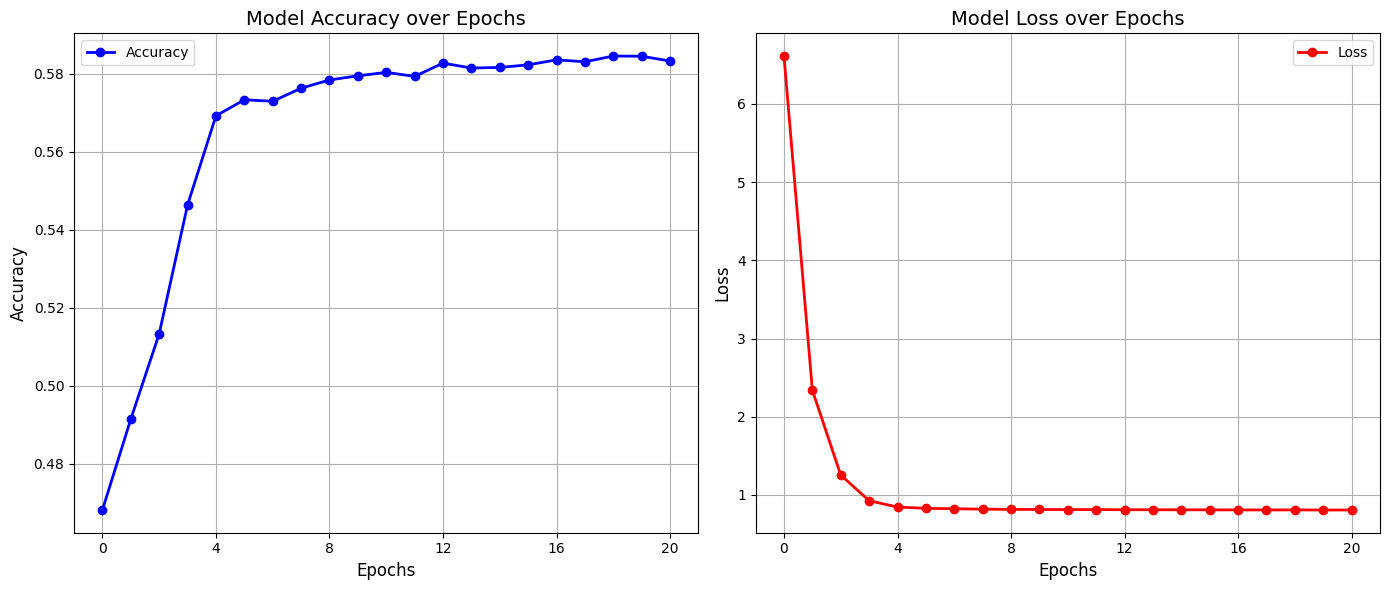

In [128]:
accs = history.history["acc"]
losses = history.history["loss"]

epochs = history.epoch


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accs, color="blue", marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('Model Accuracy over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend(['Accuracy'], loc='best')
plt.xticks(np.arange(min(epochs), max(epochs) + 1, 4))

plt.subplot(1, 2, 2)
plt.plot(epochs, losses, color="red", marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('Model Loss over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend(['Loss'], loc='best')
plt.xticks(np.arange(min(epochs), max(epochs) + 1, 4))

plt.tight_layout()
plt.show()

- Sử dụng các giá trị softmax để đưa ra dự đoán (VD: [0.1, 0.3, 0.6] => predict: 2)

In [121]:
y_preds = np.array([np.argmax(pred) for pred in model.predict(X0_test)])
y_preds.shape

2036/2036 ━━━━━━━━━━━━━━━━━━━━ 2s 847us/step


(65151,)

In [129]:
print(metrics.classification_report(Y0_test, y_preds, digits=4))

              precision    recall  f1-score   support

           0     0.5854    0.1791    0.2743      6275
           1     0.6028    0.8214    0.6953     37165
           2     0.4918    0.2852    0.3610     21711

    accuracy                         0.5809     65151
   macro avg     0.5600    0.4286    0.4436     65151
weighted avg     0.5641    0.5809    0.5434     65151



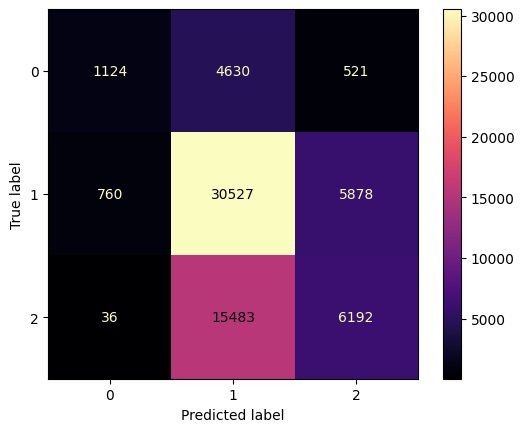

In [123]:
cm = metrics.confusion_matrix(Y0_test, y_preds)
metrics.ConfusionMatrixDisplay(cm).plot(cmap="magma")